# **ATS RE 604 Computer Vision**

### **Mahdi Ni'am Ma'ruf**
### **4222201055**
### **Robotika Pagi B**

## **Process raw dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Load dataset
data = pd.read_csv("emnist-letters-train.csv", header=None)

In [ ]:
# Shuffle untuk mengacak data
data = shuffle(data, random_state=42).reset_index(drop=True)

# Pisahkan label dan gambar
labels = data.iloc[:, 0].values
images = data.iloc[:, 1:].values.reshape(-1, 28, 28)

# Ubah label 1-26 ke huruf A-Z
label_dict = {i: chr(64+i) for i in range(1, 27)}
labels_alpha = np.array([label_dict[lbl] for lbl in labels])

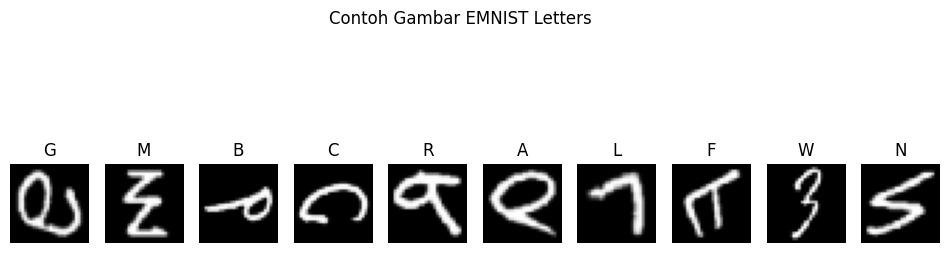

In [ ]:
# Tampilkan 10 gambar pertama
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(images[i], cmap='grey')
    plt.title(labels_alpha[i])
    plt.axis('off')
plt.suptitle("Contoh Gambar EMNIST Letters")
plt.show()

In [ ]:
# Ambil 100 data per huruf
selected_idx = []
for i in range(1, 27):
    idx = np.where(labels == i)[0][:100]
    selected_idx.extend(idx)

X_selected = images[selected_idx]
y_selected = labels[selected_idx]
y_selected_alpha = labels_alpha[selected_idx]

## **Implement HOG feature extraction**

In [ ]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# Ekstraksi fitur HOG
hog_features = []
for img in X_selected:
    feat = hog(img, orientations=12, pixels_per_cell=(4,4),
               cells_per_block=(3,3), block_norm='L2-Hys')
    hog_features.append(feat)

hog_features = np.array(hog_features)

In [ ]:
# Cek dan buang nilai NaN atau inf
mask_valid = np.all(np.isfinite(hog_features), axis=1)
hog_valid = hog_features[mask_valid]
y_valid = y_selected[mask_valid]

# Normalisasi
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_valid)

## **Implement Support Vector Machine classifier**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# Split train-test 80:20
X_train, X_test, y_train, y_test = train_test_split(
    hog_scaled, y_valid, test_size=0.2, random_state=42, stratify=y_valid)

# Parameter SVM yang dicoba
param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf']
}

In [ ]:
# Grid Search
svm_clf = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
svm_clf.fit(X_train, y_train)

print("Best Parameters:", svm_clf.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## **Evaluate the performance matrices**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

y_pred = svm_clf.predict(X_test)

print(f"Akurasi : {accuracy_score(y_test, y_pred):.4f}")
print(f"Presisi : {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall  : {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")

Akurasi : 0.8173
Presisi : 0.8215
Recall  : 0.8173
F1 Score: 0.8169


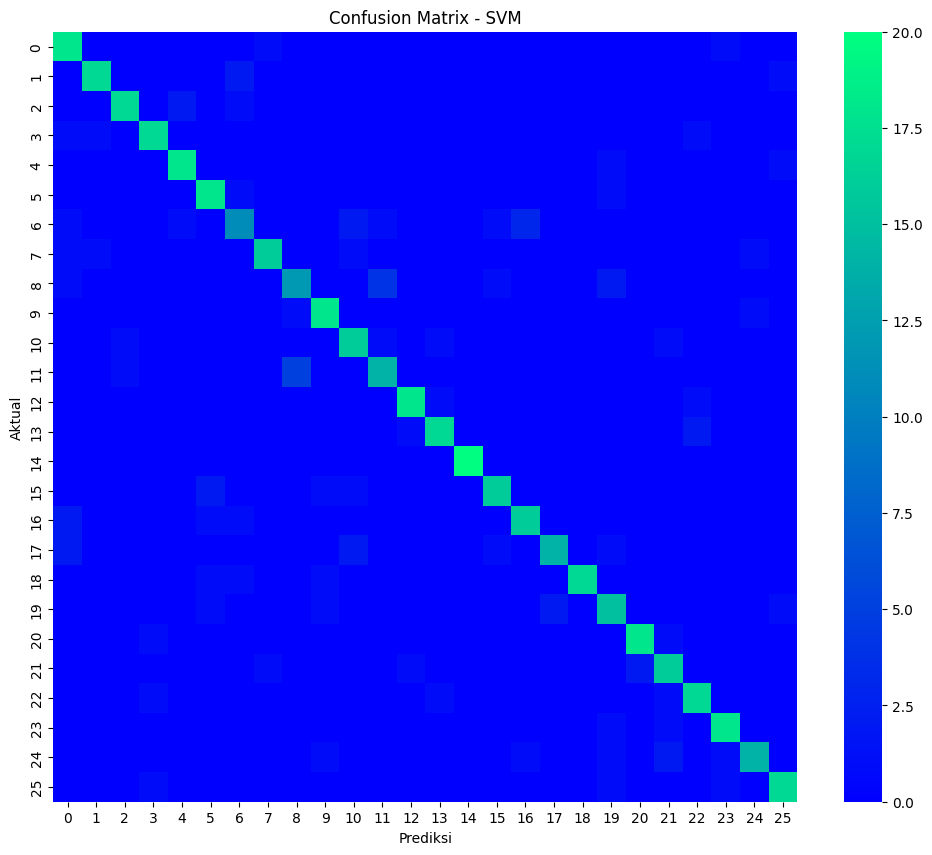

In [ ]:
# Confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap='winter')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

## **Leave One Out Cross Validation (LOOCV)**


In [ ]:
from sklearn.model_selection import LeaveOneOut

# Gunakan subset: 26 huruf × 25 kelas = 650 data
idx_650 = []
for i in range(1, 27):
    idx = np.where(y_selected == i)[0][:25]
    idx_650.extend(idx)

X_loocv = scaler.transform(hog_features[idx_650])
y_loocv = y_selected[idx_650]

# LOOCV Setup
loo = LeaveOneOut()
svm_best = SVC(**svm_clf.best_params_)

y_true_loo = []
y_pred_loo = []

for train_idx, test_idx in loo.split(X_loocv):
    X_tr, X_te = X_loocv[train_idx], X_loocv[test_idx]
    y_tr, y_te = y_loocv[train_idx], y_loocv[test_idx]

    svm_best.fit(X_tr, y_tr)
    pred = svm_best.predict(X_te)
    y_true_loo.append(y_te[0])
    y_pred_loo.append(pred[0])

print("Evaluasi LOOCV (25 sampel):")
print(f"Akurasi : {accuracy_score(y_true_loo, y_pred_loo):.4f}")
print(f"Presisi : {precision_score(y_true_loo, y_pred_loo, average='macro'):.4f}")
print(f"Recall  : {recall_score(y_true_loo, y_pred_loo, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_true_loo, y_pred_loo, average='macro'):.4f}")

Evaluasi LOOCV (25 sampel):
Akurasi : 0.7200
Presisi : 0.7281
Recall  : 0.7200
F1 Score: 0.7199


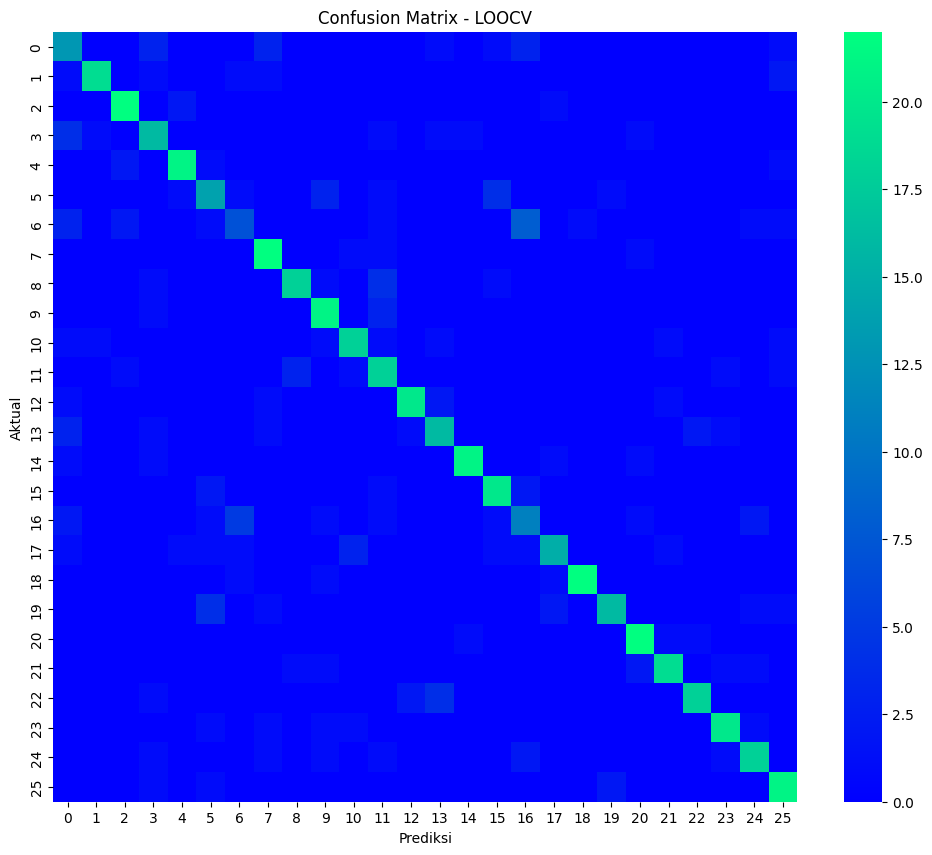

In [ ]:
# Confusion matrix LOOCV
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_true_loo, y_pred_loo), cmap="winter", annot=False)
plt.title("Confusion Matrix - LOOCV")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()